# HW1. Multinomial Naive Bayes Classifier

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Import Datasets

In [2]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

#글의 종류를 나타내는 듯 하다.

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

## Select Categories and Split datasets

In [3]:
#카테고리를 전부해도 되지만, 많아지면 복잡하니까 몇 개만 골라보자.

categories = ['talk.religion.misc', 'soc.religion.christian',
             'sci.space', 'comp.windows.x']

# 예시에서 comp.graphics를 골랐는데 나는 고르니까 에러가 뜨더라. 이유는 모르겠음. 
# 아마 train, test 분리할 때 에러가 뜨는 듯. 그래서 comp.windows.x로 변경.

train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [4]:
print(train.data[5])

From: b.liddicott@ic.ac.uk
Subject: Re: He has risen!
Organization: Imperial College Parapsychology Group
Lines: 8
NNTP-Posting-Host: cs.utexas.edu



Just to remark that I have heard that David Koresh has risen from 
the dead.  I dont know if it is true or not, but this is what I have
been told.  What do you guys think?

Ben L.




## Model Fitting

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline


#Naive Bayes를 이용해서 Model Fitting을 해보자.

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

#Pipeline을 이용하면 데이터에 대한 전처리와 model fitting을 동시에 할 수 있다는 장점이 있다.
#TfidfVectorizer에 대한 설명
#https://datascienceschool.net/view-notebook/3e7aadbf88ed4f0d87a76f9ddc925d69/

In [6]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

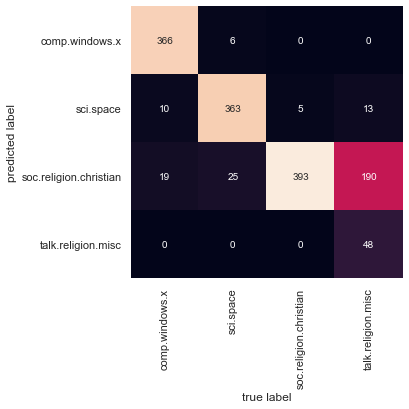

In [7]:
#얼마나 잘 맞춰는지 Confusion Matrix를 통해 시각적으로 알아보자.

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
plt.figure(figsize=(5,5))
ax = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=train.target_names, yticklabels=train.target_names)
buttom, top = ax.get_ylim()
ax.set_ylim(buttom+0.5, top-0.5)
plt.xlabel('true label')
plt.ylabel('predicted label');

#

## Making Classifier

In [8]:
#이제 어떠한 글을 넣었을 때 이것이 무슨 카테고리의 글일지 예측해보는 Classifier를 만들어보자.

def predict_category(s, train = train, model = model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [9]:
predict_category('sending a payload to the ISS')

'comp.windows.x'

In [10]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [11]:
predict_category('determining the screen resolution')

'comp.windows.x'

# HW2 Wine Classifier

## 1. EDA

### 1-1. Load the data

In [12]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
df=pd.read_csv('Wine.csv',header=None)

In [14]:
#Column들에 이름을 붙여주자.

df.columns = ['name'
              ,'alcohol'
              ,'malicAcid'
              ,'ash'
              ,'ashalcalinity'
              ,'magnesium'
              ,'totalPhenols'
              ,'flavanoids'
              ,'nonFlavanoidPhenols'
              ,'proanthocyanins'
              ,'colorIntensity'
              ,'hue'
              ,'od280_od315'
              ,'proline'
                ]

df.head(3)

,name,alcohol,malicAcid,ash,ashalcalinity,magnesium,totalPhenols,flavanoids,nonFlavanoidPhenols,proanthocyanins,colorIntensity,hue,od280_od315,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


### 1-2. Check null

In [15]:
df.isnull().sum()

#다행히 null data는 없다.

name                   0
alcohol                0
malicAcid              0
ash                    0
ashalcalinity          0
magnesium              0
totalPhenols           0
flavanoids             0
nonFlavanoidPhenols    0
proanthocyanins        0
colorIntensity         0
hue                    0
od280_od315            0
proline                0
dtype: int64

### 1-3. Correlation

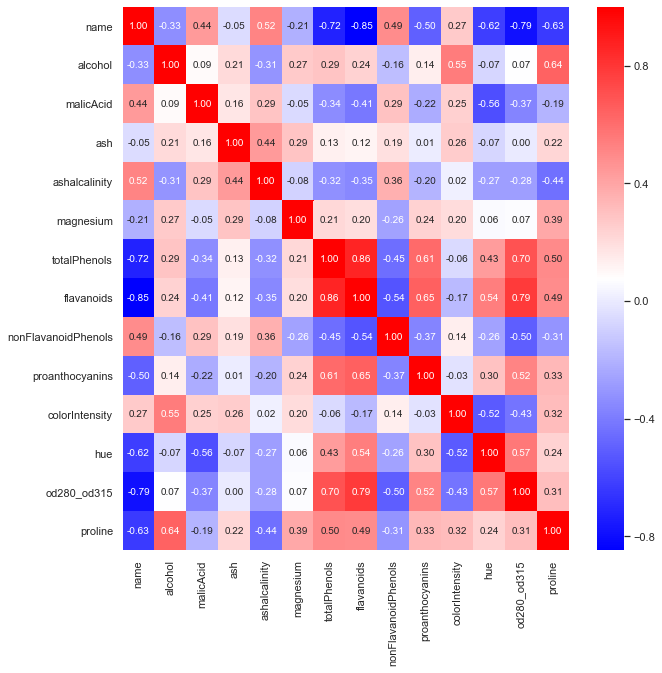

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
htm = sns.heatmap(df.corr(), annot=True, ax=ax, fmt='.2f', cmap='bwr')
buttom, top = htm.get_ylim()
ax.set_ylim(buttom+0.5, top-0.5);

#전체적으로 빨간색과 파란색이 두드러지는 걸 보니까 correlation이 강함 --> Feature Selection 필요

### 1-4. Feature Selection

In [17]:
X = df[df.columns.difference(['name'])]
y = df['name']

### 1-4-1. Univariate Selection Method

In [18]:
#우선 Univariate Selection은 그룹내 분산이 작고 그룹간 분산이 클 경우 값이 커지는 F-value를 이용하여 변수를 선택한다. 
#각 변수마다 F값을 구해 F값이 큰 변수를 기준으로 변수를 선택하는 방법이다.

from sklearn.feature_selection import SelectKBest, f_classif

selectK = SelectKBest(score_func=f_classif, k=7)
X = selectK.fit_transform(X, y)

print('Column Numbers:', X.shape[1])

#변수가 7개 선택되었다. k=7으로 두었기 때문

Column Numbers: 7


In [19]:
X_df = pd.DataFrame(X)

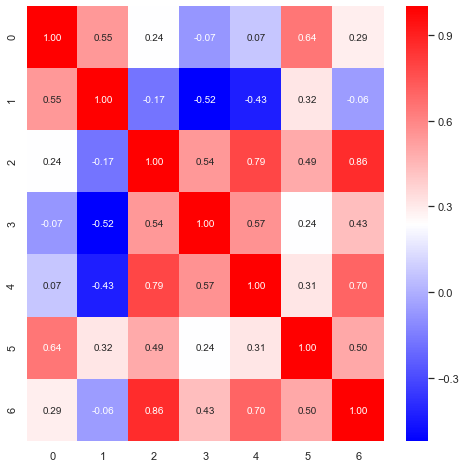

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
htm = sns.heatmap(X_df.corr(), annot=True, fmt='.2f', cmap='bwr')
buttom, top = htm.get_ylim()
ax.set_ylim(buttom+0.5, top-0.5);

#아까보다 Correlation이 좀 더 낮은 애들이 뽑혔다.

### 1-4-2. ExtraTrees Method

In [32]:
# ExtraTreesClassifier와 같은 트리 기반 모델은 Feature Importance 를 제공한다. 
# 이 Feature Importance는 불확실도를 많이 낮출수록 증가하므로 이를 기준으로 변수를 선택할 수 있다.


from sklearn.ensemble import ExtraTreesClassifier

X = df[df.columns.difference(['name'])]
y = df['name']

etc_model = ExtraTreesClassifier()
etc_model.fit(X, y)

print(etc_model.feature_importances_)
feature_list = pd.concat([pd.Series(X.columns), pd.Series(etc_model.feature_importances_)], axis=1)
feature_list.columns = ['features_name', 'importance']
feature_list.sort_values("importance", ascending =False)[:5]

#importance가 0.1이 넘는 애들만 골라보았다.

[0.11254681 0.02454529 0.03961355 0.10464428 0.10067493 0.08968567
 0.03316512 0.01271913 0.03781498 0.17766026 0.01833232 0.20034205
 0.0482556 ]


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,features_name,importance
11,proline,0.200342
9,od280_od315,0.177660
0,alcohol,0.112547
3,colorIntensity,0.104644
4,flavanoids,0.100675


In [33]:
X = df[['proline', 'flavanoids', 'alcohol','od280_od315', 'colorIntensity']]
y = df['name']
print('Column Numbers:', X.shape[1])

Column Numbers: 5


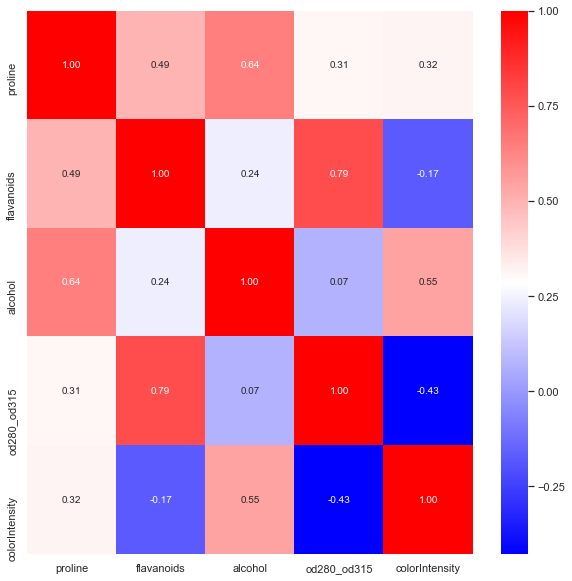

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
htm = sns.heatmap(X.corr(), annot=True, fmt='.2f', cmap='bwr')
buttom, top = htm.get_ylim()
ax.set_ylim(buttom+0.5, top-0.5);

In [46]:
# 뒤의 방식을 택하기로 한다. (그냥)

## 2. Train-Test Split

In [36]:
# Train과 Test 분리

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_train.head(3)

(142, 5) (142,)
(36, 5) (36,)


,proline,flavanoids,alcohol,od280_od315,colorIntensity
84,520,2.21,11.84,3.08,3.05
11,1280,2.43,14.12,2.82,5.00
168,750,0.84,13.58,1.80,8.66


## 3. Model Fitting

### 3-1. LDA & QDA

In [45]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
print('LDA Train score:', round(lda.score(X_train, y_train), 4))
print('LDA Test score:', round(lda.score(X_test, y_test),4))

# QDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis().fit(X_train,y_train)
print('QDA Train score:', round(qda.score(X_train, y_train),3))
print('QDA Test score:', round(qda.score(X_test, y_test),3))

LDA Train score: 0.9718
LDA Test score: 0.9722
QDA Train score: 0.979
QDA Test score: 1.0


### 3-2. Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
Logi = LogisticRegression(solver='sag', max_iter=10000, multi_class='auto').fit(X_train, y_train)
print('Logi Train score:', round(Logi.score(X_train, y_train),3))
print('Logi Test score:', round(Logi.score(X_test, y_test),3))

Logi Train score: 0.887
Logi Test score: 0.917


### 3-3. Logistic Regression with feature expansion

In [39]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

for i in range(1,4):
    poly = PolynomialFeatures(degree=i, include_bias=False)
    X_poly = poly.fit_transform(X_train)
    Logreg = LogisticRegression(solver='sag', max_iter=10000, multi_class='auto')
    kcv_score = cross_val_score(Logreg, X_poly, y_train, cv=5) 
    print('%d poly score:' %i , round(kcv_score.mean(),3))
    
# 몇 차인지에 따라 kcv score를 매겨보니까 그냥 1차가 제일 좋다. 변수들이 많아서 그런 것일 수도!

1 poly score: 0.888
2 poly score: 0.868
3 poly score: 0.575


### 4. conclusion

In [41]:
print('Score Comparision','\n','\n'
      'LDA Test score:', round(lda.score(X_test, y_test),3), '\n'
      'QDA Test score:', round(qda.score(X_test, y_test),3), '\n'
      'Logi Test score:', round(Logi.score(X_test, y_test),3))

Score Comparision 
 
LDA Test score: 0.972 
QDA Test score: 1.0 
Logi Test score: 0.917


In [31]:
# Choose QDA
# 하지만 test score가 너무 높음. 더 많은 데이터가 필요.